In [1]:
!pip install --upgrade tf_slim

import numpy.random as rnd
import numpy as np
import tensorflow as tf
import tf_slim as slim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import label_binarize
from collections import deque
import random

/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sheila/

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_random_seed(seed)#tf.random.set_seed(seed)
random.seed(seed)

In [3]:
numOfEpisodes = 300
numTimeSlots = 1000

discount_rate = 0.618 # gamma
learning_rate = 0.7 # Learning rate

# Epsilon greedy parameters
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.01
epsilon_vec = np.zeros((numOfEpisodes,))

maxNofCollisions = 3

batch_size = 128

MIN_REPLAY_SIZE = 1000

state = label_binarize([0, 1, 2, 3], classes=[0, 1, 2, 3])
print("Matriz dos Estados:")
print(state, "\n")

state_size  = state.shape[0]
action_size = 4

print("Numero de Estados:", state_size)
print("Numero de Acoes:", action_size)

Matriz dos Estados:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] 

Numero de Estados: 4
Numero de Acoes: 4


In [4]:
def createModel(state_size, action_size, loss='mse'):
  learning_rate = 0.01
  init = tf.keras.initializers.he_uniform()#tf.keras.initializers.HeUniform()
  model = keras.Sequential()
  # Input layer - número dos estados de entrada
  model.add(keras.layers.Dense(state_size, input_shape=(state_size,), activation='relu', kernel_initializer=init))
  # Output layer - número de ações no ambiente
  model.add(keras.layers.Dense(action_size, activation='linear', kernel_initializer=init))
  if(loss=='huber'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.Huber(), metrics=['accuracy'])
    print('Using Huber loss...')
  elif(loss=='mse'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
    print('Using MSE loss...')
  else:
    print('Loss not defined...')
  return model

def train(replay_memory, model, model_target, collisionCnt, batch_size, acc_history=[], loss_history=[]):
  mini_batch = random.sample(replay_memory, batch_size)
  c_states = np.array([transition[0] for transition in mini_batch])
  current_qs_list  = model.predict(c_states)
  n_states = np.array([transition[3] for transition in mini_batch])
  future_qs_list = model_target.predict(n_states)

  X = []
  Y = []
  for index, (c_state, action, reward, n_state, collisionCnt) in enumerate(mini_batch):
    if collisionCnt != maxNofCollisions:
        max_future_q = reward + discount_rate * np.max(future_qs_list[index])
    else:
        max_future_q = reward

    current_qs = current_qs_list[index]
    current_qs[action] = max_future_q

    X.append(c_state)
    Y.append(current_qs)

  # Train model with a mini-batch.
  history = model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

  # Store metrics.
  acc_history.append(history.history['acc'][0])
  loss_history.append(history.history['loss'][0])

  return history

In [5]:
# The first model makes the predictions for Q-values which are used to make a action.
model = createModel(state_size, action_size)
# Build a target model for the prediction of future rewards.
model_target = createModel(state_size, action_size)
# Initialize target model's weights.
model_target.set_weights(model.get_weights())

Using MSE loss...
Using MSE loss...


In [6]:
model.metrics_names

['loss', 'acc']

In [7]:
acc_history = []
loss_history = []

episode_reward = np.zeros((numOfEpisodes,))
max_reward =  np.zeros((numOfEpisodes,))
replay_memory = deque(maxlen=50_000)

steps_to_update_target_model = 0
for episode in range(numOfEpisodes):

  print('Episode:', episode)

  collisionCnt = 0
  for iteration in range(numTimeSlots):

      steps_to_update_target_model += 1
      
      print("Time Slot   :", iteration)
      print("----------------------")
      
      # Estado atual.
      c_state = state[iteration % 4,:] # seleciona um estado por vez (uma linha por vez)
      print("Estado atual:", c_state)
          
      # Escolha da ação.
      if np.random.uniform() >= epsilon:
          predicted = model.predict(c_state.reshape(1,4))
          action = np.argmax(predicted[0])
          print("Action (Q):", action)
      else:
          action = np.random.randint(0, state_size)
          print("Action (rnd):", action)
      
      # Proximo estado - apenas para representação.
      n_state = state[(iteration + 1) % 4] # seleciona uma linha a seguir +1 por vez
      print("Next State  :", n_state)
      
      c_s_index = np.argwhere(c_state==1)[0][0]
      #print("indice do estado atual", c_s_index)
      
      n_s_index = np.argwhere(n_state)[0][0]
      #print("indice do proximo estado", n_s_index, "\n")
      
      # Reward.
      if action == n_s_index:
          reward = -1.0
          collisionCnt += 1
      else:
          reward = 1.0

      # Add information to replay buffer.
      replay_memory.append([c_state, action, reward, n_state, collisionCnt])          

      # Accumulate reward.
      episode_reward[episode] += reward
      
      # Plot received reward.
      print("Reward      :", reward)
      print("-------------", "\n")      

      # Train
      if len(replay_memory) >= MIN_REPLAY_SIZE:
        history = train(replay_memory, model, model_target, collisionCnt, batch_size, acc_history, loss_history)

      # Is it the end of the episode?
      if(collisionCnt == maxNofCollisions):
        # Update the the target network with new weights
        model_target.set_weights(model.get_weights())
        collisionCnt = 0
        print('########## Game Over ##########')
        break

  # Store maxmim possible reward per episode.
  max_reward[episode] = iteration + 1
  
  # Decrease epsilon along the way.
  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
  epsilon_vec[episode] = epsilon

  print('episode_reward:', episode_reward[episode])

Episode: 0
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
--------------

Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 0.0
Episode: 12
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------

Action (Q): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward 

------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 8
---------

----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 1.0
Episode: 52
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
-------------

########## Game Over ##########
episode_reward: 1.0
Episode: 61
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      :

Action (Q): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 1.0
Episode: 68
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estad

Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Esta

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atu

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado

Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado at

Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 12.0
Episode: 104
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [

----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 46
----------------------
Est

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 16.0
Episode: 109
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      :

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Est

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado a

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado 

########## Game Over ##########
episode_reward: 19.0
Episode: 119
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1

Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Est

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Esta

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estad

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Est

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estad

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado

Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estad

Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Rew

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 25.0
Episode: 142
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward    

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Est

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atu

Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward    

Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   

Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
----

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Est

Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado


Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
E

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
E

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 86.0
Episode: 156
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward   

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Es

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado a

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado a

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 20.0
Episode: 162
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0


Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Es

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Esta

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado

Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
----

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado a

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 46.0
Episode: 172
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 

Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado

Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Rewa

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 28.0
Episode: 178
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      :

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Est

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 19
----------------------
Es

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Esta

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado a

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado

Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward  

Time Slot   : 101
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 102
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------

Time Slot   : 178
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 179
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 180
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 181
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 182
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 183
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 184
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 185
-------------------

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado a

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado a

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado a

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estad

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estad

Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward

Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward  

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 57.0
Episode: 198
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado a

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado a

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado a

Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward  

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado

Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward  

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado a

Time Slot   : 164
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 165
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 166
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 167
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 168
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 169
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 170
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 171
---------------------

Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward  

Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward    

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Est

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Est

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Est

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Est

Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward    

Time Slot   : 126
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 127
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 129
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 130
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 131
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
-------------------

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 208
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 209
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 210
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 211
---------------------

Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward  

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado a

Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado a

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado a

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 125
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 126
----------------------


########## Game Over ##########
episode_reward: 61.0
Episode: 223
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
--

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 39.0
Episode: 225
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0

Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward    

Time Slot   : 131
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------


Time Slot   : 199
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 200
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 201
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------


Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado a

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 107.0
Episode: 227
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Rewar

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Esta

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estad

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------


Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 96
----------------------
Estado a

Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
--

Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 142
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------


Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
E

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 125
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 126
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 127
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 129
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 130
-------------------

Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado a

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado a

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado a

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 142.0
Episode: 237
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      :

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estad

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Est

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estad

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 54
----------------------
Est

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado


Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 148
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 149
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 150
--------------------

Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward  

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------


Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 49.0
Episode: 244
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_rew

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado a

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado a

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------


Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado a

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado a

Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 98
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 99
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 100
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 101
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 102
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Esta

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------


Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 172
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 173
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 174
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 175
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 176
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 177
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 178
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado a

----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1

Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado a

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado

Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Rewar

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
---------------------

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 67.0
Episode: 257
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 

Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------


Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado

Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 100
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 101
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 102
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0

Time Slot   : 169
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 170
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 171
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 172
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 173
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 174
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 175
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 176
----------------------


Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Esta

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado a

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado a

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
---------------------

Time Slot   : 184
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 185
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 186
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 187
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 188
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 189
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 190
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 191
----------------------


Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward  

Reward      : 1.0
------------- 

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time 

Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward  

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado a

########## Game Over ##########
episode_reward: 102.0
Episode: 265
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
----

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado a

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 142
----------------------


Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atu

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State  : [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
E

Time Slot   : 95
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 96
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 97
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 98
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 99
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 100
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 101
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 102
----------------------
Estad

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado a

Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
R

Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 180
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 181
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 182
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 183
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 184
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 185
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 186
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Rew

Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 250
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 251
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 252
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 253
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 254
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 255
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 256
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Rew

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado a

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado a

Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 163
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 164
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 165
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Rew

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado a

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------


Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 200
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 201
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Nex

Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 285
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 286
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 287
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 288
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 289
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 290
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 291
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      :

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado a

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado a

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 125
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 126
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 127
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 129
----------------------


Time Slot   : 208
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 209
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 210
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 211
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 212
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 213
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 214
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 215
----------------------


Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward    

Time Slot   : 151
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 152
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 153
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 154
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 155
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 156
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 157
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 158
-------------------

----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Actio

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 96
----------------------
Estado a

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado a

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 117
------------------

Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 195
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 196
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 197
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 198
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 199
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Rew

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado a

Time Slot   : 125
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 126
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 127
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 129
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 130
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 131
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 132
----------------------


Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Esta

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Esta

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado a

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------


Time Slot   : 200
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 201
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------


Time Slot   : 264
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 265
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 266
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 267
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 268
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 269
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 270
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 271
----------------------


Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado a

Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 158
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 163
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 164
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0

Time Slot   : 241
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 242
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 243
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 244
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 245
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 246
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 247
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 248
----------------------


Time Slot   : 328
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 329
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 330
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 331
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 332
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 333
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 334
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 335
----------------------


Time Slot   : 405
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 406
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 407
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 408
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 409
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 410
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 411
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 412
----------------------


Time Slot   : 475
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 476
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 477
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 478
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 479
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 480
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 481
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 482
----------------------


Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 125
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 126
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 127
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 129
--------------------

Time Slot   : 187
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 188
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 189
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 190
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 191
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 192
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------


Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: 

Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State

Time Slot   : 168
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 169
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 170
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 171
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 172
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 173
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 174
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 175
---------------------

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado a

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------


Time Slot   : 190
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 191
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 192
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 195
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 196
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 197
-------------------

Time Slot   : 274
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 275
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 276
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 277
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 278
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 279
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 280
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 281
----------------------


Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado a

Time Slot   : 155
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 156
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 157
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 158
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 162
---------------------

Time Slot   : 239
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State  : [1 0 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 234.0
Episode: 287
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado a

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado a

Time Slot   : 142
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 148
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 149
----------------------


Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
----

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------


Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado a

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado a

Time Slot   : 96
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 97
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 98
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 99
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 100
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 101
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 102
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 103
----------------------
Esta

Time Slot   : 180
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 181
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 182
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 183
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 184
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 185
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 186
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 187
---------------------

Time Slot   : 264
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 265
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 266
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 267
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 268
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 269
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 270
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 271
----------------------


Time Slot   : 348
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 349
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 350
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 351
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 352
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 353
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 354
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 355
---------------------

Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 433
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 434
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 435
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 436
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 437
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 438
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 439
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Rew

Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 

Time Slot   : 158
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 163
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 164
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 165
---------------------

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado a

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 142
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------


Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado a

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 142
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
---------------------

----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
A

Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 148
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 149
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 150
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 151
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Rew

Time Slot   : 227
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 228
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 229
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 230
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 231
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 232
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 233
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 234
----------------------


Time Slot   : 313
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 314
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 315
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 316
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State  : [0 1 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 311.0
Episode: 296
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State  : [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward  

Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado a

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado a

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------


Time Slot   : 189
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 190
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 191
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 192
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 195
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 196
----------------------


Action (Q): 3
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State  : [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State  : [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State  : [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State  : [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State  : [0 0 0 1]
Reward    

In [15]:
 for idx in range(state_size):

    c_state = state[idx]
    print("Estado atual:", c_state)
 
    q = model.predict(c_state.reshape(1,4))
    print('Q:',q[0])
    print('-----\n')

Estado atual: [1 0 0 0]
Q: [2.6610076  0.15983516 2.6496067  2.656186  ]
-----

Estado atual: [0 1 0 0]
Q: [ 2.6272037   2.6189814  -0.10221517  2.6227179 ]
-----

Estado atual: [0 0 1 0]
Q: [2.6857228  2.6702445  2.6824205  0.00680964]
-----

Estado atual: [0 0 0 1]
Q: [0.19644946 2.6909034  2.712605   2.660063  ]
-----



In [16]:
 for idx in range(state_size):

    c_state = state[idx]
    print("Estado atual:", c_state)
 
    q = model_target.predict(c_state.reshape(1,4))
    print('Q:',q[0])
    print('-----\n')

Estado atual: [1 0 0 0]
Q: [2.6610076  0.15983516 2.6496067  2.656186  ]
-----

Estado atual: [0 1 0 0]
Q: [ 2.6272037   2.6189814  -0.10221517  2.6227179 ]
-----

Estado atual: [0 0 1 0]
Q: [2.6857228  2.6702445  2.6824205  0.00680964]
-----

Estado atual: [0 0 0 1]
Q: [0.19644946 2.6909034  2.712605   2.660063  ]
-----



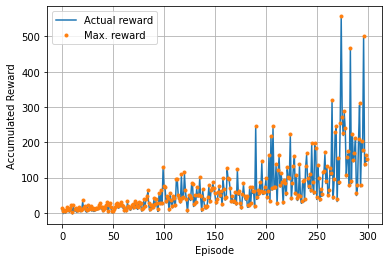

In [17]:
plt.plot(episode_reward, label='Actual reward')
plt.plot(max_reward, '.', label='Max. reward')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.grid()
plt.legend()
plt.show()

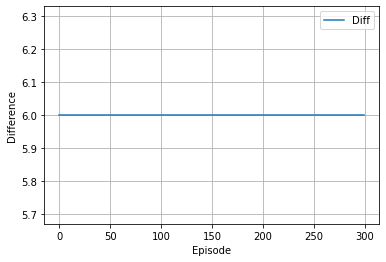

In [18]:
diff  = max_reward - episode_reward
plt.plot(diff, label='Diff')
plt.xlabel('Episode')
plt.ylabel('Difference')
plt.grid()
plt.legend()
plt.show()

In [19]:
print(max_reward[250:300])
print(episode_reward[250:300])

[ 44. 135.  98.  39.  68.  53. 115. 118. 171.  89. 132.  52.  65. 128.
 112. 319.  45.  96. 230. 245.  38. 155.  87. 255. 557. 272. 225. 288.
 240. 108. 159. 174.  80. 468.  89. 224. 151. 170. 212.  55.  80. 208.
 311.  80. 203. 179. 502. 139. 163. 152.]
[ 38. 129.  92.  33.  62.  47. 109. 112. 165.  83. 126.  46.  59. 122.
 106. 313.  39.  90. 224. 239.  32. 149.  81. 249. 551. 266. 219. 282.
 234. 102. 153. 168.  74. 462.  83. 218. 145. 164. 206.  49.  74. 202.
 305.  74. 197. 173. 496. 133. 157. 146.]


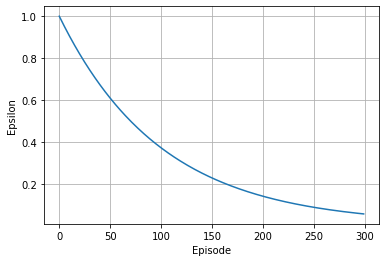

In [20]:
plt.plot(epsilon_vec)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid()
plt.show()

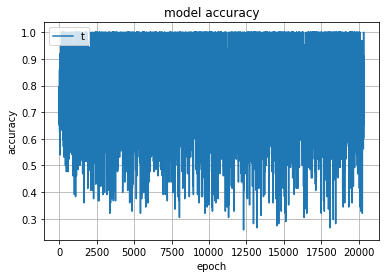

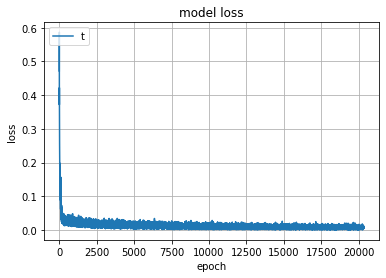

In [21]:
# summarize history for accuracy
plt.plot(acc_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()